In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 수집한 데이터

In [93]:
data = pd.read_excel('./data/samsung10.xlsx')
data

,DATE,거래량,PER,PBR,기관 합계,기타법인,개인,외국인 합계,ATR,NASDAQ,S&P,CBOE,Exchange rate,futures2y,futures10y,y
0,2011-09-01,35870550,7.27,1.24,-83833734000,-8749641000,-177822918000,270406293000,880,"2,546.00","1,204.42",31.82,"1,064.40",110.28,130.61,16160
1,2011-09-02,12934100,7.26,1.23,-7185878000,2125969000,-11377060000,16436969000,360,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,16220
2,2011-09-05,13874400,6.90,1.17,-975699000,-215641000,29370756000,-28179416000,780,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,16260
3,2011-09-06,13225250,6.86,1.17,2349662000,-1299409000,13839817000,-14890070000,520,"2,473.80","1,165.24",37.00,"1,074.65",110.27,131.22,15800
4,2011-09-07,17575200,7.29,1.24,113232351000,1123519000,-77907268000,-36448602000,1020,"2,548.90","1,198.62",33.38,"1,069.65",110.27,130.89,15160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,2021-08-25,22319664,19.71,1.92,-76990474100,-8894667500,82373232300,3511909300,1700,"15,041.90","4,496.19",16.79,"1,163.87",110.25,133.63,0
2457,2021-08-26,16671494,19.42,1.89,-55566537800,9344981600,142574757300,-96353201100,1600,"14,945.80","4,469.91",18.84,"1,170.53",110.25,133.59,0
2458,2021-08-27,15172748,19.34,1.89,173118394100,10372274300,1510887500,-185001555900,1200,"15,129.50","4,509.37",16.39,"1,161.23",110.30,133.89,0
2459,2021-08-30,12686999,19.42,1.89,24586418600,-2401179400,54715193800,-76900433000,1300,"15,265.90","4,528.79",16.19,"1,164.34",110.32,134.13,0


In [94]:
data = data.drop(index = [2451,2452,2453,2454,2455,2456,2457,2458,2459,2460], axis=0)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2450
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           2451 non-null   datetime64[ns]
 1   거래량            2451 non-null   int64         
 2   PER            2451 non-null   float64       
 3   PBR            2451 non-null   float64       
 4   기관 합계          2451 non-null   int64         
 5   기타법인           2451 non-null   int64         
 6   개인             2451 non-null   int64         
 7   외국인 합계         2451 non-null   int64         
 8   ATR            2451 non-null   int64         
 9   NASDAQ         2451 non-null   object        
 10  S&P            2451 non-null   object        
 11  CBOE           2451 non-null   float64       
 12  Exchange rate  2451 non-null   object        
 13  futures2y      2451 non-null   float64       
 14  futures10y     2451 non-null   float64       
 15  y              2451 n

In [19]:
# 실수형으로 변환

data['CBOE'] = data['CBOE'].astype('float')
data['futures2y'] = data['futures2y'].astype('float')
data['futures10y'] = data['futures10y'].astype('float')

In [20]:
# 실수형으로 변환(값에 ','가 포함된 경우)

data['NASDAQ'] = data['NASDAQ'].str.replace(',', '').astype(float)
data['S&P'] = data['S&P'].str.replace(',', '').astype(float)
data['Exchange rate'] = data['Exchange rate'].str.replace(',', '').astype(float)

In [21]:
scaler = MinMaxScaler()

In [22]:
scale_cols = ['거래량', 'PER', 'PBR', '기관 합계', '기타법인', '개인', '외국인 합계', 'ATR', 'NASDAQ', 'S&P', 'CBOE', 'Exchange rate', 'futures2y', 'futures10y', 'y']

In [23]:
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[0.37435295, 0.07735281, 0.07361963, ..., 0.95700935, 0.57105031,
        0.01318565],
       [0.11073659, 0.07692308, 0.06748466, ..., 0.95140187, 0.60150044,
        0.01397679],
       [0.12154377, 0.06145251, 0.03067485, ..., 0.95140187, 0.60150044,
        0.01450422],
       ...,
       [0.44899842, 0.6265578 , 0.50920245, ..., 0.94766355, 0.69638129,
        0.77979958],
       [0.6662848 , 0.59733563, 0.47239264, ..., 0.95327103, 0.7184466 ,
        0.78375527],
       [0.31774018, 0.59518694, 0.46625767, ..., 0.95327103, 0.7325684 ,
        0.81144515]])

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], test_size=0.2, random_state=0, shuffle=False)

In [26]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1960, 14), (1960,), (491, 14), (491,))

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
WINDOW_SIZE=120
BATCH_SIZE=32

In [29]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [30]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 120, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [31]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [32]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [41]:
earlystopping = EarlyStopping(monitor='val_loss', patience=300, mode='min')
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [42]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=2000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/2000
58/58 [==============================] - 3s 53ms/step - loss: 5.6539e-05 - mse: 1.1308e-04 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00001: val_loss improved from inf to 0.00224, saving model to tmp\ckeckpointer.ckpt
Epoch 2/2000
58/58 [==============================] - 4s 57ms/step - loss: 5.5682e-05 - mse: 1.1136e-04 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00002: val_loss improved from 0.00224 to 0.00223, saving model to tmp\ckeckpointer.ckpt
Epoch 3/2000
58/58 [==============================] - 3s 43ms/step - loss: 5.6962e-05 - mse: 1.1392e-04 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00003: val_loss did not improve from 0.00223
Epoch 4/2000
58/58 [==============================] - 3s 45ms/step - loss: 5.8229e-05 - mse: 1.1646e-04 - val_loss: 0.0026 - val_mse: 0.0051

Epoch 00004: val_loss did not improve from 0.00223
Epoch 5/2000
58/58 [==============================] - 3s 45ms/step - loss: 5.8427e-05 - mse: 1.1685e-04 - val_loss: 0.0027 - val_mse: 0.0053

Epoc

58/58 [==============================] - 5s 71ms/step - loss: 4.6427e-05 - mse: 9.2854e-05 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00042: val_loss did not improve from 0.00216
Epoch 43/2000
58/58 [==============================] - 3s 50ms/step - loss: 4.4859e-05 - mse: 8.9718e-05 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00043: val_loss did not improve from 0.00216
Epoch 44/2000
58/58 [==============================] - 5s 82ms/step - loss: 4.6907e-05 - mse: 9.3814e-05 - val_loss: 0.0027 - val_mse: 0.0055

Epoch 00044: val_loss did not improve from 0.00216
Epoch 45/2000
58/58 [==============================] - 5s 74ms/step - loss: 4.2010e-05 - mse: 8.4019e-05 - val_loss: 0.0026 - val_mse: 0.0052

Epoch 00045: val_loss did not improve from 0.00216
Epoch 46/2000
58/58 [==============================] - 3s 44ms/step - loss: 4.3970e-05 - mse: 8.7941e-05 - val_loss: 0.0026 - val_mse: 0.0052

Epoch 00046: val_loss did not improve from 0.00216
Epoch 47/2000
58/58 [=======================

58/58 [==============================] - 6s 97ms/step - loss: 3.5821e-05 - mse: 7.1641e-05 - val_loss: 0.0031 - val_mse: 0.0061

Epoch 00084: val_loss did not improve from 0.00198
Epoch 85/2000
58/58 [==============================] - 7s 116ms/step - loss: 3.5548e-05 - mse: 7.1095e-05 - val_loss: 0.0028 - val_mse: 0.0057

Epoch 00085: val_loss did not improve from 0.00198
Epoch 86/2000
58/58 [==============================] - 5s 82ms/step - loss: 3.7547e-05 - mse: 7.5094e-05 - val_loss: 0.0029 - val_mse: 0.0058

Epoch 00086: val_loss did not improve from 0.00198
Epoch 87/2000
58/58 [==============================] - 5s 85ms/step - loss: 3.7287e-05 - mse: 7.4575e-05 - val_loss: 0.0025 - val_mse: 0.0049

Epoch 00087: val_loss did not improve from 0.00198
Epoch 88/2000
58/58 [==============================] - 5s 80ms/step - loss: 3.6686e-05 - mse: 7.3373e-05 - val_loss: 0.0024 - val_mse: 0.0049

Epoch 00088: val_loss did not improve from 0.00198
Epoch 89/2000
58/58 [======================


Epoch 00125: val_loss did not improve from 0.00198
Epoch 126/2000
58/58 [==============================] - 6s 99ms/step - loss: 3.2064e-05 - mse: 6.4128e-05 - val_loss: 0.0029 - val_mse: 0.0058e-

Epoch 00126: val_loss did not improve from 0.00198
Epoch 127/2000
58/58 [==============================] - 7s 109ms/step - loss: 3.1330e-05 - mse: 6.2659e-05 - val_loss: 0.0027 - val_mse: 0.0054

Epoch 00127: val_loss did not improve from 0.00198
Epoch 128/2000
58/58 [==============================] - 7s 117ms/step - loss: 3.4150e-05 - mse: 6.8299e-05 - val_loss: 0.0030 - val_mse: 0.0059

Epoch 00128: val_loss did not improve from 0.00198
Epoch 129/2000
58/58 [==============================] - 8s 121ms/step - loss: 3.2195e-05 - mse: 6.4391e-05 - val_loss: 0.0030 - val_mse: 0.0059

Epoch 00129: val_loss did not improve from 0.00198
Epoch 130/2000
58/58 [==============================] - 6s 88ms/step - loss: 3.3818e-05 - mse: 6.7637e-05 - val_loss: 0.0031 - val_mse: 0.0062

Epoch 00130: val_lo

58/58 [==============================] - 5s 75ms/step - loss: 2.9154e-05 - mse: 5.8309e-05 - val_loss: 0.0020 - val_mse: 0.00405 - mse:

Epoch 00167: val_loss did not improve from 0.00198
Epoch 168/2000
58/58 [==============================] - 5s 77ms/step - loss: 2.9891e-05 - mse: 5.9783e-05 - val_loss: 0.0023 - val_mse: 0.0045

Epoch 00168: val_loss did not improve from 0.00198
Epoch 169/2000
58/58 [==============================] - 6s 90ms/step - loss: 3.4225e-05 - mse: 6.8449e-05 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00169: val_loss improved from 0.00198 to 0.00178, saving model to tmp\ckeckpointer.ckpt
Epoch 170/2000
58/58 [==============================] - 6s 100ms/step - loss: 3.4141e-05 - mse: 6.8283e-05 - val_loss: 0.0021 - val_mse: 0.0043

Epoch 00170: val_loss did not improve from 0.00178
Epoch 171/2000
58/58 [==============================] - 6s 100ms/step - loss: 2.9138e-05 - mse: 5.8277e-05 - val_loss: 0.0023 - val_mse: 0.0046

Epoch 00171: val_loss did not improve 

58/58 [==============================] - 6s 92ms/step - loss: 3.2790e-05 - mse: 6.5581e-05 - val_loss: 0.0022 - val_mse: 0.0045

Epoch 00208: val_loss did not improve from 0.00162
Epoch 209/2000
58/58 [==============================] - 5s 82ms/step - loss: 3.0929e-05 - mse: 6.1858e-05 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00209: val_loss did not improve from 0.00162
Epoch 210/2000
58/58 [==============================] - 5s 81ms/step - loss: 3.1823e-05 - mse: 6.3646e-05 - val_loss: 0.0020 - val_mse: 0.0040

Epoch 00210: val_loss did not improve from 0.00162
Epoch 211/2000
58/58 [==============================] - 5s 82ms/step - loss: 3.0803e-05 - mse: 6.1605e-05 - val_loss: 0.0023 - val_mse: 0.0047e-0

Epoch 00211: val_loss did not improve from 0.00162
Epoch 212/2000
58/58 [==============================] - 5s 84ms/step - loss: 3.2492e-05 - mse: 6.4983e-05 - val_loss: 0.0021 - val_mse: 0.0042

Epoch 00212: val_loss did not improve from 0.00162
Epoch 213/2000
58/58 [===============

58/58 [==============================] - 3s 51ms/step - loss: 3.0632e-05 - mse: 6.1264e-05 - val_loss: 0.0016 - val_mse: 0.0031

Epoch 00249: val_loss did not improve from 0.00130
Epoch 250/2000
58/58 [==============================] - 3s 52ms/step - loss: 3.1404e-05 - mse: 6.2807e-05 - val_loss: 0.0020 - val_mse: 0.0039

Epoch 00250: val_loss did not improve from 0.00130
Epoch 251/2000
58/58 [==============================] - 3s 52ms/step - loss: 3.1929e-05 - mse: 6.3858e-05 - val_loss: 0.0015 - val_mse: 0.0030

Epoch 00251: val_loss did not improve from 0.00130
Epoch 252/2000
58/58 [==============================] - 4s 58ms/step - loss: 3.2981e-05 - mse: 6.5962e-05 - val_loss: 0.0015 - val_mse: 0.0031

Epoch 00252: val_loss did not improve from 0.00130
Epoch 253/2000
58/58 [==============================] - 4s 56ms/step - loss: 2.9973e-05 - mse: 5.9946e-05 - val_loss: 0.0015 - val_mse: 0.0030

Epoch 00253: val_loss did not improve from 0.00130
Epoch 254/2000
58/58 [==================


Epoch 00290: val_loss did not improve from 0.00115
Epoch 291/2000
58/58 [==============================] - 3s 50ms/step - loss: 3.0743e-05 - mse: 6.1486e-05 - val_loss: 0.0016 - val_mse: 0.0032

Epoch 00291: val_loss did not improve from 0.00115
Epoch 292/2000
58/58 [==============================] - 3s 53ms/step - loss: 3.2368e-05 - mse: 6.4736e-05 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00292: val_loss did not improve from 0.00115
Epoch 293/2000
58/58 [==============================] - 4s 56ms/step - loss: 3.2858e-05 - mse: 6.5716e-05 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00293: val_loss did not improve from 0.00115
Epoch 294/2000
58/58 [==============================] - 3s 53ms/step - loss: 2.9695e-05 - mse: 5.9390e-05 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00294: val_loss did not improve from 0.00115
Epoch 295/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.9916e-05 - mse: 5.9832e-05 - val_loss: 0.0011 - val_mse: 0.0023e

Epoch 00295: val_loss i

Epoch 331/2000
58/58 [==============================] - 4s 61ms/step - loss: 3.0227e-05 - mse: 6.0454e-05 - val_loss: 0.0010 - val_mse: 0.0020

Epoch 00331: val_loss did not improve from 0.00085
Epoch 332/2000
58/58 [==============================] - 4s 58ms/step - loss: 2.9354e-05 - mse: 5.8709e-05 - val_loss: 0.0011 - val_mse: 0.0021

Epoch 00332: val_loss did not improve from 0.00085
Epoch 333/2000
58/58 [==============================] - 3s 55ms/step - loss: 3.0651e-05 - mse: 6.1302e-05 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00333: val_loss did not improve from 0.00085
Epoch 334/2000
58/58 [==============================] - 4s 57ms/step - loss: 2.9623e-05 - mse: 5.9246e-05 - val_loss: 0.0010 - val_mse: 0.0020

Epoch 00334: val_loss did not improve from 0.00085
Epoch 335/2000
58/58 [==============================] - 4s 58ms/step - loss: 3.2564e-05 - mse: 6.5128e-05 - val_loss: 0.0012 - val_mse: 0.0025

Epoch 00335: val_loss did not improve from 0.00085
Epoch 336/2000
58/58 [===

58/58 [==============================] - 3s 47ms/step - loss: 3.0691e-05 - mse: 6.1383e-05 - val_loss: 7.4326e-04 - val_mse: 0.0015

Epoch 00372: val_loss improved from 0.00078 to 0.00074, saving model to tmp\ckeckpointer.ckpt
Epoch 373/2000
58/58 [==============================] - 3s 45ms/step - loss: 3.1782e-05 - mse: 6.3564e-05 - val_loss: 8.4743e-04 - val_mse: 0.0017

Epoch 00373: val_loss did not improve from 0.00074
Epoch 374/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9232e-05 - mse: 5.8465e-05 - val_loss: 8.7668e-04 - val_mse: 0.0018

Epoch 00374: val_loss did not improve from 0.00074
Epoch 375/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.9670e-05 - mse: 5.9339e-05 - val_loss: 9.9988e-04 - val_mse: 0.0020

Epoch 00375: val_loss did not improve from 0.00074
Epoch 376/2000
58/58 [==============================] - 3s 48ms/step - loss: 3.0428e-05 - mse: 6.0856e-05 - val_loss: 8.0481e-04 - val_mse: 0.0016

Epoch 00376: val_loss did no

58/58 [==============================] - 3s 48ms/step - loss: 2.9994e-05 - mse: 5.9987e-05 - val_loss: 0.0011 - val_mse: 0.0021

Epoch 00412: val_loss did not improve from 0.00053
Epoch 413/2000
58/58 [==============================] - 4s 56ms/step - loss: 2.9499e-05 - mse: 5.8999e-05 - val_loss: 7.3522e-04 - val_mse: 0.0015

Epoch 00413: val_loss did not improve from 0.00053
Epoch 414/2000
58/58 [==============================] - 4s 56ms/step - loss: 2.9419e-05 - mse: 5.8839e-05 - val_loss: 8.2502e-04 - val_mse: 0.0017

Epoch 00414: val_loss did not improve from 0.00053
Epoch 415/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.8986e-05 - mse: 5.7972e-05 - val_loss: 7.2379e-04 - val_mse: 0.0014

Epoch 00415: val_loss did not improve from 0.00053
Epoch 416/2000
58/58 [==============================] - 3s 52ms/step - loss: 3.1475e-05 - mse: 6.2950e-05 - val_loss: 0.0012 - val_mse: 0.0023

Epoch 00416: val_loss did not improve from 0.00053
Epoch 417/2000
58/58 [======

58/58 [==============================] - 3s 47ms/step - loss: 2.8867e-05 - mse: 5.7734e-05 - val_loss: 7.3095e-04 - val_mse: 0.0015

Epoch 00453: val_loss did not improve from 0.00039
Epoch 454/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.9723e-05 - mse: 5.9446e-05 - val_loss: 8.3376e-04 - val_mse: 0.0017

Epoch 00454: val_loss did not improve from 0.00039
Epoch 455/2000
58/58 [==============================] - 3s 49ms/step - loss: 3.1101e-05 - mse: 6.2202e-05 - val_loss: 6.7636e-04 - val_mse: 0.0014

Epoch 00455: val_loss did not improve from 0.00039
Epoch 456/2000
58/58 [==============================] - 3s 49ms/step - loss: 3.1850e-05 - mse: 6.3701e-05 - val_loss: 9.7932e-04 - val_mse: 0.0020

Epoch 00456: val_loss did not improve from 0.00039
Epoch 457/2000
58/58 [==============================] - 3s 51ms/step - loss: 2.9101e-05 - mse: 5.8202e-05 - val_loss: 6.9381e-04 - val_mse: 0.0014

Epoch 00457: val_loss did not improve from 0.00039
Epoch 458/2000
58/58

58/58 [==============================] - 3s 48ms/step - loss: 2.8857e-05 - mse: 5.7715e-05 - val_loss: 7.6499e-04 - val_mse: 0.0015

Epoch 00494: val_loss did not improve from 0.00039
Epoch 495/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.9214e-05 - mse: 5.8428e-05 - val_loss: 6.6510e-04 - val_mse: 0.0013

Epoch 00495: val_loss did not improve from 0.00039
Epoch 496/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.8805e-05 - mse: 5.7610e-05 - val_loss: 7.2148e-04 - val_mse: 0.0014

Epoch 00496: val_loss did not improve from 0.00039
Epoch 497/2000
58/58 [==============================] - 3s 41ms/step - loss: 3.0853e-05 - mse: 6.1706e-05 - val_loss: 4.9434e-04 - val_mse: 9.8868e-04

Epoch 00497: val_loss did not improve from 0.00039
Epoch 498/2000
58/58 [==============================] - 3s 52ms/step - loss: 3.2925e-05 - mse: 6.5850e-05 - val_loss: 6.0644e-04 - val_mse: 0.0012

Epoch 00498: val_loss did not improve from 0.00039
Epoch 499/2000
5

58/58 [==============================] - 3s 49ms/step - loss: 2.9055e-05 - mse: 5.8110e-05 - val_loss: 5.6880e-04 - val_mse: 0.0011

Epoch 00535: val_loss did not improve from 0.00039
Epoch 536/2000
58/58 [==============================] - 3s 49ms/step - loss: 3.0773e-05 - mse: 6.1546e-05 - val_loss: 4.0152e-04 - val_mse: 8.0303e-04

Epoch 00536: val_loss did not improve from 0.00039
Epoch 537/2000
58/58 [==============================] - 3s 47ms/step - loss: 3.0854e-05 - mse: 6.1707e-05 - val_loss: 5.8812e-04 - val_mse: 0.0012

Epoch 00537: val_loss did not improve from 0.00039
Epoch 538/2000
58/58 [==============================] - 3s 47ms/step - loss: 3.0762e-05 - mse: 6.1525e-05 - val_loss: 5.2157e-04 - val_mse: 0.0010

Epoch 00538: val_loss did not improve from 0.00039
Epoch 539/2000
58/58 [==============================] - 3s 45ms/step - loss: 3.3023e-05 - mse: 6.6046e-05 - val_loss: 7.9239e-04 - val_mse: 0.0016

Epoch 00539: val_loss did not improve from 0.00039
Epoch 540/2000
5

58/58 [==============================] - 3s 45ms/step - loss: 2.8878e-05 - mse: 5.7755e-05 - val_loss: 5.3775e-04 - val_mse: 0.0011

Epoch 00576: val_loss did not improve from 0.00036
Epoch 577/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.9697e-05 - mse: 5.9394e-05 - val_loss: 5.1406e-04 - val_mse: 0.0010

Epoch 00577: val_loss did not improve from 0.00036
Epoch 578/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9090e-05 - mse: 5.8180e-05 - val_loss: 5.8819e-04 - val_mse: 0.0012

Epoch 00578: val_loss did not improve from 0.00036
Epoch 579/2000
58/58 [==============================] - 3s 43ms/step - loss: 3.2451e-05 - mse: 6.4902e-05 - val_loss: 6.5158e-04 - val_mse: 0.0013

Epoch 00579: val_loss did not improve from 0.00036
Epoch 580/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9236e-05 - mse: 5.8472e-05 - val_loss: 4.7076e-04 - val_mse: 9.4152e-04

Epoch 00580: val_loss did not improve from 0.00036
Epoch 581/2000
5

58/58 [==============================] - 3s 46ms/step - loss: 2.9813e-05 - mse: 5.9625e-05 - val_loss: 4.8609e-04 - val_mse: 9.7218e-04

Epoch 00617: val_loss did not improve from 0.00036
Epoch 618/2000
58/58 [==============================] - 3s 45ms/step - loss: 3.1216e-05 - mse: 6.2432e-05 - val_loss: 4.3193e-04 - val_mse: 8.6385e-04

Epoch 00618: val_loss did not improve from 0.00036
Epoch 619/2000
58/58 [==============================] - 3s 43ms/step - loss: 2.9395e-05 - mse: 5.8791e-05 - val_loss: 3.9833e-04 - val_mse: 7.9666e-04

Epoch 00619: val_loss did not improve from 0.00036
Epoch 620/2000
58/58 [==============================] - 3s 44ms/step - loss: 3.3282e-05 - mse: 6.6563e-05 - val_loss: 4.7615e-04 - val_mse: 9.5230e-04

Epoch 00620: val_loss did not improve from 0.00036
Epoch 621/2000
58/58 [==============================] - 3s 48ms/step - loss: 3.3239e-05 - mse: 6.6478e-05 - val_loss: 4.9740e-04 - val_mse: 9.9481e-04

Epoch 00621: val_loss did not improve from 0.00036


58/58 [==============================] - 3s 45ms/step - loss: 3.0924e-05 - mse: 6.1848e-05 - val_loss: 4.1334e-04 - val_mse: 8.2669e-04

Epoch 00658: val_loss did not improve from 0.00036
Epoch 659/2000
58/58 [==============================] - 3s 42ms/step - loss: 3.2128e-05 - mse: 6.4257e-05 - val_loss: 4.4053e-04 - val_mse: 8.8105e-04

Epoch 00659: val_loss did not improve from 0.00036
Epoch 660/2000
58/58 [==============================] - 3s 44ms/step - loss: 3.0405e-05 - mse: 6.0810e-05 - val_loss: 4.4164e-04 - val_mse: 8.8329e-04

Epoch 00660: val_loss did not improve from 0.00036
Epoch 661/2000
58/58 [==============================] - 3s 43ms/step - loss: 2.8460e-05 - mse: 5.6921e-05 - val_loss: 5.8555e-04 - val_mse: 0.0012

Epoch 00661: val_loss did not improve from 0.00036
Epoch 662/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8124e-05 - mse: 5.6248e-05 - val_loss: 4.8145e-04 - val_mse: 9.6290e-04

Epoch 00662: val_loss did not improve from 0.00036
Epoc

58/58 [==============================] - 3s 47ms/step - loss: 2.9193e-05 - mse: 5.8387e-05 - val_loss: 3.8291e-04 - val_mse: 7.6582e-04

Epoch 00698: val_loss did not improve from 0.00032
Epoch 699/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.8884e-05 - mse: 5.7768e-05 - val_loss: 4.5367e-04 - val_mse: 9.0734e-04

Epoch 00699: val_loss did not improve from 0.00032
Epoch 700/2000
58/58 [==============================] - 3s 46ms/step - loss: 2.9870e-05 - mse: 5.9739e-05 - val_loss: 4.9697e-04 - val_mse: 9.9394e-04

Epoch 00700: val_loss did not improve from 0.00032
Epoch 701/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.9230e-05 - mse: 5.8460e-05 - val_loss: 5.0080e-04 - val_mse: 0.0010

Epoch 00701: val_loss did not improve from 0.00032
Epoch 702/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8624e-05 - mse: 5.7248e-05 - val_loss: 5.7396e-04 - val_mse: 0.0011

Epoch 00702: val_loss did not improve from 0.00032
Epoch 70


Epoch 00738: val_loss did not improve from 0.00032
Epoch 739/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9209e-05 - mse: 5.8418e-05 - val_loss: 5.0673e-04 - val_mse: 0.0010

Epoch 00739: val_loss did not improve from 0.00032
Epoch 740/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.8729e-05 - mse: 5.7459e-05 - val_loss: 3.8799e-04 - val_mse: 7.7598e-04

Epoch 00740: val_loss did not improve from 0.00032
Epoch 741/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.9374e-05 - mse: 5.8747e-05 - val_loss: 6.2989e-04 - val_mse: 0.0013

Epoch 00741: val_loss did not improve from 0.00032
Epoch 742/2000
58/58 [==============================] - 3s 46ms/step - loss: 2.9044e-05 - mse: 5.8088e-05 - val_loss: 5.6438e-04 - val_mse: 0.0011

Epoch 00742: val_loss did not improve from 0.00032
Epoch 743/2000
58/58 [==============================] - 3s 43ms/step - loss: 3.0584e-05 - mse: 6.1168e-05 - val_loss: 6.6046e-04 - val_mse: 0.0013



58/58 [==============================] - 3s 44ms/step - loss: 2.9709e-05 - mse: 5.9418e-05 - val_loss: 5.0857e-04 - val_mse: 0.0010

Epoch 00779: val_loss did not improve from 0.00032
Epoch 780/2000
58/58 [==============================] - 3s 43ms/step - loss: 3.0737e-05 - mse: 6.1475e-05 - val_loss: 4.5936e-04 - val_mse: 9.1872e-04

Epoch 00780: val_loss did not improve from 0.00032
Epoch 781/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8881e-05 - mse: 5.7763e-05 - val_loss: 5.8062e-04 - val_mse: 0.0012

Epoch 00781: val_loss did not improve from 0.00032
Epoch 782/2000
58/58 [==============================] - 3s 43ms/step - loss: 2.8827e-05 - mse: 5.7653e-05 - val_loss: 4.4201e-04 - val_mse: 8.8401e-04

Epoch 00782: val_loss did not improve from 0.00032
Epoch 783/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8730e-05 - mse: 5.7461e-05 - val_loss: 5.0793e-04 - val_mse: 0.0010

Epoch 00783: val_loss did not improve from 0.00032
Epoch 784/20

58/58 [==============================] - 4s 74ms/step - loss: 2.8765e-05 - mse: 5.7529e-05 - val_loss: 5.2715e-04 - val_mse: 0.0011

Epoch 00820: val_loss did not improve from 0.00032
Epoch 821/2000
58/58 [==============================] - 5s 74ms/step - loss: 3.0752e-05 - mse: 6.1505e-05 - val_loss: 6.4026e-04 - val_mse: 0.0013

Epoch 00821: val_loss did not improve from 0.00032
Epoch 822/2000
58/58 [==============================] - 5s 76ms/step - loss: 2.8898e-05 - mse: 5.7796e-05 - val_loss: 5.3578e-04 - val_mse: 0.0011

Epoch 00822: val_loss did not improve from 0.00032
Epoch 823/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.8588e-05 - mse: 5.7175e-05 - val_loss: 4.7769e-04 - val_mse: 9.5537e-04

Epoch 00823: val_loss did not improve from 0.00032
Epoch 824/2000
58/58 [==============================] - 3s 48ms/step - loss: 2.9773e-05 - mse: 5.9547e-05 - val_loss: 4.9065e-04 - val_mse: 9.8130e-04

Epoch 00824: val_loss did not improve from 0.00032
Epoch 825/20

58/58 [==============================] - 4s 60ms/step - loss: 2.9856e-05 - mse: 5.9713e-05 - val_loss: 5.5528e-04 - val_mse: 0.0011

Epoch 00861: val_loss did not improve from 0.00032
Epoch 862/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8475e-05 - mse: 5.6949e-05 - val_loss: 5.6385e-04 - val_mse: 0.0011

Epoch 00862: val_loss did not improve from 0.00032
Epoch 863/2000
58/58 [==============================] - 3s 51ms/step - loss: 2.9413e-05 - mse: 5.8827e-05 - val_loss: 7.4438e-04 - val_mse: 0.0015

Epoch 00863: val_loss did not improve from 0.00032
Epoch 864/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.8901e-05 - mse: 5.7801e-05 - val_loss: 7.4910e-04 - val_mse: 0.0015

Epoch 00864: val_loss did not improve from 0.00032
Epoch 865/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.9865e-05 - mse: 5.9730e-05 - val_loss: 5.1571e-04 - val_mse: 0.0010

Epoch 00865: val_loss did not improve from 0.00032
Epoch 866/2000
58/58

58/58 [==============================] - 4s 63ms/step - loss: 2.8617e-05 - mse: 5.7234e-05 - val_loss: 9.4633e-04 - val_mse: 0.0019

Epoch 00902: val_loss did not improve from 0.00032
Epoch 903/2000
58/58 [==============================] - 4s 58ms/step - loss: 2.9220e-05 - mse: 5.8439e-05 - val_loss: 9.3406e-04 - val_mse: 0.0019

Epoch 00903: val_loss did not improve from 0.00032
Epoch 904/2000
58/58 [==============================] - 4s 57ms/step - loss: 2.9756e-05 - mse: 5.9511e-05 - val_loss: 7.9068e-04 - val_mse: 0.0016

Epoch 00904: val_loss did not improve from 0.00032
Epoch 905/2000
58/58 [==============================] - 3s 53ms/step - loss: 3.2353e-05 - mse: 6.4705e-05 - val_loss: 3.9354e-04 - val_mse: 7.8708e-04

Epoch 00905: val_loss did not improve from 0.00032
Epoch 906/2000
58/58 [==============================] - 4s 67ms/step - loss: 2.9892e-05 - mse: 5.9784e-05 - val_loss: 4.1201e-04 - val_mse: 8.2401e-04

Epoch 00906: val_loss did not improve from 0.00032
Epoch 907/20

58/58 [==============================] - 3s 48ms/step - loss: 2.8679e-05 - mse: 5.7359e-05 - val_loss: 3.6470e-04 - val_mse: 7.2940e-04

Epoch 00942: val_loss did not improve from 0.00029
Epoch 943/2000
58/58 [==============================] - 3s 57ms/step - loss: 2.8297e-05 - mse: 5.6594e-05 - val_loss: 4.0873e-04 - val_mse: 8.1745e-04

Epoch 00943: val_loss did not improve from 0.00029
Epoch 944/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.8647e-05 - mse: 5.7294e-05 - val_loss: 3.1142e-04 - val_mse: 6.2284e-04

Epoch 00944: val_loss did not improve from 0.00029
Epoch 945/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.8403e-05 - mse: 5.6805e-05 - val_loss: 4.7331e-04 - val_mse: 9.4662e-04

Epoch 00945: val_loss did not improve from 0.00029
Epoch 946/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.7909e-05 - mse: 5.5817e-05 - val_loss: 3.5543e-04 - val_mse: 7.1087e-04

Epoch 00946: val_loss did not improve from 0.00029


58/58 [==============================] - 4s 56ms/step - loss: 2.9189e-05 - mse: 5.8378e-05 - val_loss: 6.6417e-04 - val_mse: 0.0013

Epoch 00982: val_loss did not improve from 0.00029
Epoch 983/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.9001e-05 - mse: 5.8002e-05 - val_loss: 4.3894e-04 - val_mse: 8.7788e-04

Epoch 00983: val_loss did not improve from 0.00029
Epoch 984/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.9624e-05 - mse: 5.9247e-05 - val_loss: 4.0823e-04 - val_mse: 8.1646e-04

Epoch 00984: val_loss did not improve from 0.00029
Epoch 985/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.8818e-05 - mse: 5.7637e-05 - val_loss: 4.5812e-04 - val_mse: 9.1624e-04

Epoch 00985: val_loss did not improve from 0.00029
Epoch 986/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.9599e-05 - mse: 5.9198e-05 - val_loss: 4.2273e-04 - val_mse: 8.4546e-04

Epoch 00986: val_loss did not improve from 0.00029
Epoc

58/58 [==============================] - 3s 49ms/step - loss: 2.8290e-05 - mse: 5.6579e-05 - val_loss: 5.0647e-04 - val_mse: 0.0010

Epoch 01022: val_loss did not improve from 0.00029
Epoch 1023/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8085e-05 - mse: 5.6171e-05 - val_loss: 5.2111e-04 - val_mse: 0.0010

Epoch 01023: val_loss did not improve from 0.00029
Epoch 1024/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.9280e-05 - mse: 5.8561e-05 - val_loss: 4.1921e-04 - val_mse: 8.3843e-04

Epoch 01024: val_loss did not improve from 0.00029
Epoch 1025/2000
58/58 [==============================] - 3s 48ms/step - loss: 2.8625e-05 - mse: 5.7249e-05 - val_loss: 3.8707e-04 - val_mse: 7.7414e-04

Epoch 01025: val_loss did not improve from 0.00029
Epoch 1026/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.7947e-05 - mse: 5.5894e-05 - val_loss: 3.2093e-04 - val_mse: 6.4186e-04

Epoch 01026: val_loss did not improve from 0.00029
Epoc

58/58 [==============================] - 3s 49ms/step - loss: 2.8894e-05 - mse: 5.7788e-05 - val_loss: 4.6550e-04 - val_mse: 9.3101e-04

Epoch 01062: val_loss did not improve from 0.00028
Epoch 1063/2000
58/58 [==============================] - 3s 47ms/step - loss: 2.9143e-05 - mse: 5.8285e-05 - val_loss: 4.4049e-04 - val_mse: 8.8098e-04

Epoch 01063: val_loss did not improve from 0.00028
Epoch 1064/2000
58/58 [==============================] - 3s 46ms/step - loss: 2.9885e-05 - mse: 5.9769e-05 - val_loss: 5.9885e-04 - val_mse: 0.0012

Epoch 01064: val_loss did not improve from 0.00028
Epoch 1065/2000
58/58 [==============================] - 3s 48ms/step - loss: 3.1686e-05 - mse: 6.3371e-05 - val_loss: 4.2474e-04 - val_mse: 8.4947e-04

Epoch 01065: val_loss did not improve from 0.00028
Epoch 1066/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.9541e-05 - mse: 5.9083e-05 - val_loss: 4.1745e-04 - val_mse: 8.3490e-04

Epoch 01066: val_loss did not improve from 0.00028


58/58 [==============================] - 3s 49ms/step - loss: 2.9930e-05 - mse: 5.9859e-05 - val_loss: 4.8271e-04 - val_mse: 9.6542e-04

Epoch 01102: val_loss did not improve from 0.00025
Epoch 1103/2000
58/58 [==============================] - 3s 56ms/step - loss: 2.8374e-05 - mse: 5.6748e-05 - val_loss: 4.2801e-04 - val_mse: 8.5602e-04

Epoch 01103: val_loss did not improve from 0.00025
Epoch 1104/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.8506e-05 - mse: 5.7011e-05 - val_loss: 2.8631e-04 - val_mse: 5.7263e-04

Epoch 01104: val_loss did not improve from 0.00025
Epoch 1105/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.9115e-05 - mse: 5.8230e-05 - val_loss: 4.5108e-04 - val_mse: 9.0216e-04

Epoch 01105: val_loss did not improve from 0.00025
Epoch 1106/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.8662e-05 - mse: 5.7324e-05 - val_loss: 4.0048e-04 - val_mse: 8.0096e-04

Epoch 01106: val_loss did not improve from 0.00

58/58 [==============================] - 3s 46ms/step - loss: 2.9724e-05 - mse: 5.9448e-05 - val_loss: 3.3885e-04 - val_mse: 6.7770e-04

Epoch 01142: val_loss did not improve from 0.00025
Epoch 1143/2000
58/58 [==============================] - 4s 57ms/step - loss: 2.8282e-05 - mse: 5.6564e-05 - val_loss: 4.0955e-04 - val_mse: 8.1909e-04

Epoch 01143: val_loss did not improve from 0.00025
Epoch 1144/2000
58/58 [==============================] - 4s 61ms/step - loss: 2.8690e-05 - mse: 5.7380e-05 - val_loss: 5.6174e-04 - val_mse: 0.0011

Epoch 01144: val_loss did not improve from 0.00025
Epoch 1145/2000
58/58 [==============================] - 4s 58ms/step - loss: 2.8392e-05 - mse: 5.6784e-05 - val_loss: 4.1596e-04 - val_mse: 8.3193e-04

Epoch 01145: val_loss did not improve from 0.00025
Epoch 1146/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.7923e-05 - mse: 5.5846e-05 - val_loss: 4.0044e-04 - val_mse: 8.0089e-04

Epoch 01146: val_loss did not improve from 0.00025


58/58 [==============================] - 3s 51ms/step - loss: 2.8605e-05 - mse: 5.7210e-05 - val_loss: 3.9989e-04 - val_mse: 7.9979e-04

Epoch 01182: val_loss did not improve from 0.00025
Epoch 1183/2000
58/58 [==============================] - 3s 54ms/step - loss: 2.8662e-05 - mse: 5.7325e-05 - val_loss: 3.7867e-04 - val_mse: 7.5734e-04

Epoch 01183: val_loss did not improve from 0.00025
Epoch 1184/2000
58/58 [==============================] - 4s 57ms/step - loss: 2.8309e-05 - mse: 5.6619e-05 - val_loss: 3.8915e-04 - val_mse: 7.7829e-04

Epoch 01184: val_loss did not improve from 0.00025
Epoch 1185/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.8133e-05 - mse: 5.6265e-05 - val_loss: 4.1335e-04 - val_mse: 8.2669e-04

Epoch 01185: val_loss did not improve from 0.00025
Epoch 1186/2000
58/58 [==============================] - 3s 53ms/step - loss: 2.7959e-05 - mse: 5.5918e-05 - val_loss: 3.7281e-04 - val_mse: 7.4562e-04

Epoch 01186: val_loss did not improve from 0.00

58/58 [==============================] - 4s 58ms/step - loss: 2.9529e-05 - mse: 5.9057e-05 - val_loss: 5.5388e-04 - val_mse: 0.0011

Epoch 01222: val_loss did not improve from 0.00024
Epoch 1223/2000
58/58 [==============================] - 4s 58ms/step - loss: 2.8120e-05 - mse: 5.6240e-05 - val_loss: 6.7874e-04 - val_mse: 0.0014

Epoch 01223: val_loss did not improve from 0.00024
Epoch 1224/2000
58/58 [==============================] - 4s 57ms/step - loss: 2.8680e-05 - mse: 5.7361e-05 - val_loss: 3.7959e-04 - val_mse: 7.5918e-04

Epoch 01224: val_loss did not improve from 0.00024
Epoch 1225/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.8417e-05 - mse: 5.6834e-05 - val_loss: 2.2625e-04 - val_mse: 4.5251e-04

Epoch 01225: val_loss improved from 0.00024 to 0.00023, saving model to tmp\ckeckpointer.ckpt
Epoch 1226/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8398e-05 - mse: 5.6796e-05 - val_loss: 4.7590e-04 - val_mse: 9.5181e-04

Epoch 01226:

58/58 [==============================] - 4s 53ms/step - loss: 2.8065e-05 - mse: 5.6130e-05 - val_loss: 3.7235e-04 - val_mse: 7.4471e-04

Epoch 01262: val_loss did not improve from 0.00023
Epoch 1263/2000
58/58 [==============================] - 3s 52ms/step - loss: 2.9835e-05 - mse: 5.9670e-05 - val_loss: 5.3536e-04 - val_mse: 0.0011

Epoch 01263: val_loss did not improve from 0.00023
Epoch 1264/2000
58/58 [==============================] - 4s 62ms/step - loss: 2.8067e-05 - mse: 5.6135e-05 - val_loss: 3.9051e-04 - val_mse: 7.8102e-04

Epoch 01264: val_loss did not improve from 0.00023
Epoch 1265/2000
58/58 [==============================] - 4s 56ms/step - loss: 2.8526e-05 - mse: 5.7052e-05 - val_loss: 5.8908e-04 - val_mse: 0.0012

Epoch 01265: val_loss did not improve from 0.00023
Epoch 1266/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.8450e-05 - mse: 5.6900e-05 - val_loss: 3.3618e-04 - val_mse: 6.7236e-04

Epoch 01266: val_loss did not improve from 0.00023
Epoc

58/58 [==============================] - 3s 44ms/step - loss: 2.8835e-05 - mse: 5.7670e-05 - val_loss: 4.9417e-04 - val_mse: 9.8834e-04

Epoch 01302: val_loss did not improve from 0.00023
Epoch 1303/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9598e-05 - mse: 5.9197e-05 - val_loss: 5.9696e-04 - val_mse: 0.0012

Epoch 01303: val_loss did not improve from 0.00023
Epoch 1304/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9295e-05 - mse: 5.8591e-05 - val_loss: 4.7544e-04 - val_mse: 9.5088e-04

Epoch 01304: val_loss did not improve from 0.00023
Epoch 1305/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8124e-05 - mse: 5.6248e-05 - val_loss: 6.2674e-04 - val_mse: 0.0013

Epoch 01305: val_loss did not improve from 0.00023
Epoch 1306/2000
58/58 [==============================] - 3s 47ms/step - loss: 2.8804e-05 - mse: 5.7609e-05 - val_loss: 3.5855e-04 - val_mse: 7.1710e-04

Epoch 01306: val_loss did not improve from 0.00023
Epoc

58/58 [==============================] - 3s 52ms/step - loss: 2.8768e-05 - mse: 5.7536e-05 - val_loss: 3.2314e-04 - val_mse: 6.4627e-04

Epoch 01342: val_loss did not improve from 0.00023
Epoch 1343/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8432e-05 - mse: 5.6863e-05 - val_loss: 4.5006e-04 - val_mse: 9.0012e-04

Epoch 01343: val_loss did not improve from 0.00023
Epoch 1344/2000
58/58 [==============================] - 3s 46ms/step - loss: 2.9756e-05 - mse: 5.9512e-05 - val_loss: 5.4378e-04 - val_mse: 0.0011

Epoch 01344: val_loss did not improve from 0.00023
Epoch 1345/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.9116e-05 - mse: 5.8232e-05 - val_loss: 5.4772e-04 - val_mse: 0.0011

Epoch 01345: val_loss did not improve from 0.00023
Epoch 1346/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8395e-05 - mse: 5.6790e-05 - val_loss: 4.8633e-04 - val_mse: 9.7265e-04

Epoch 01346: val_loss did not improve from 0.00023
Epoc

58/58 [==============================] - 3s 46ms/step - loss: 2.8497e-05 - mse: 5.6994e-05 - val_loss: 3.7483e-04 - val_mse: 7.4967e-04

Epoch 01382: val_loss did not improve from 0.00023
Epoch 1383/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.8871e-05 - mse: 5.7741e-05 - val_loss: 3.6184e-04 - val_mse: 7.2368e-04

Epoch 01383: val_loss did not improve from 0.00023
Epoch 1384/2000
58/58 [==============================] - 3s 46ms/step - loss: 3.0702e-05 - mse: 6.1405e-05 - val_loss: 7.3904e-04 - val_mse: 0.0015

Epoch 01384: val_loss did not improve from 0.00023
Epoch 1385/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.9081e-05 - mse: 5.8162e-05 - val_loss: 5.6431e-04 - val_mse: 0.0011

Epoch 01385: val_loss did not improve from 0.00023
Epoch 1386/2000
58/58 [==============================] - 3s 45ms/step - loss: 3.0419e-05 - mse: 6.0838e-05 - val_loss: 5.6774e-04 - val_mse: 0.0011

Epoch 01386: val_loss did not improve from 0.00023
Epoch 13


Epoch 01422: val_loss did not improve from 0.00023
Epoch 1423/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.9117e-05 - mse: 5.8233e-05 - val_loss: 7.8691e-04 - val_mse: 0.0016

Epoch 01423: val_loss did not improve from 0.00023
Epoch 1424/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8384e-05 - mse: 5.6768e-05 - val_loss: 4.5541e-04 - val_mse: 9.1081e-04

Epoch 01424: val_loss did not improve from 0.00023
Epoch 1425/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.9657e-05 - mse: 5.9314e-05 - val_loss: 5.3490e-04 - val_mse: 0.0011

Epoch 01425: val_loss did not improve from 0.00023
Epoch 1426/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.8409e-05 - mse: 5.6817e-05 - val_loss: 5.4030e-04 - val_mse: 0.0011

Epoch 01426: val_loss did not improve from 0.00023
Epoch 1427/2000
58/58 [==============================] - 3s 44ms/step - loss: 2.8548e-05 - mse: 5.7096e-05 - val_loss: 4.2912e-04 - val_mse: 8.5

58/58 [==============================] - 3s 48ms/step - loss: 2.7943e-05 - mse: 5.5886e-05 - val_loss: 4.7409e-04 - val_mse: 9.4819e-04

Epoch 01463: val_loss did not improve from 0.00023
Epoch 1464/2000
58/58 [==============================] - 3s 50ms/step - loss: 2.8322e-05 - mse: 5.6644e-05 - val_loss: 4.6962e-04 - val_mse: 9.3924e-04

Epoch 01464: val_loss did not improve from 0.00023
Epoch 1465/2000
58/58 [==============================] - 3s 48ms/step - loss: 2.9280e-05 - mse: 5.8561e-05 - val_loss: 4.7780e-04 - val_mse: 9.5560e-04

Epoch 01465: val_loss did not improve from 0.00023
Epoch 1466/2000
58/58 [==============================] - 3s 48ms/step - loss: 2.9373e-05 - mse: 5.8747e-05 - val_loss: 5.6810e-04 - val_mse: 0.0011

Epoch 01466: val_loss did not improve from 0.00023
Epoch 1467/2000
58/58 [==============================] - 3s 49ms/step - loss: 2.8422e-05 - mse: 5.6844e-05 - val_loss: 4.7328e-04 - val_mse: 9.4655e-04

Epoch 01467: val_loss did not improve from 0.00023



Epoch 01503: val_loss did not improve from 0.00023
Epoch 1504/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.8029e-05 - mse: 5.6057e-05 - val_loss: 6.1267e-04 - val_mse: 0.0012

Epoch 01504: val_loss did not improve from 0.00023
Epoch 1505/2000
58/58 [==============================] - 3s 45ms/step - loss: 2.7943e-05 - mse: 5.5886e-05 - val_loss: 5.6552e-04 - val_mse: 0.0011

Epoch 01505: val_loss did not improve from 0.00023
Epoch 1506/2000
58/58 [==============================] - 3s 46ms/step - loss: 2.7864e-05 - mse: 5.5728e-05 - val_loss: 5.8059e-04 - val_mse: 0.0012

Epoch 01506: val_loss did not improve from 0.00023
Epoch 1507/2000
58/58 [==============================] - 3s 45ms/step - loss: 3.0407e-05 - mse: 6.0814e-05 - val_loss: 4.7294e-04 - val_mse: 9.4587e-04

Epoch 01507: val_loss did not improve from 0.00023
Epoch 1508/2000
58/58 [==============================] - 3s 43ms/step - loss: 2.9089e-05 - mse: 5.8178e-05 - val_loss: 4.6426e-04 - val_mse: 9.2

In [43]:
model.load_weights(filename)

In [44]:
pred = model.predict(test_data)

In [45]:
pred.shape

(371, 1)

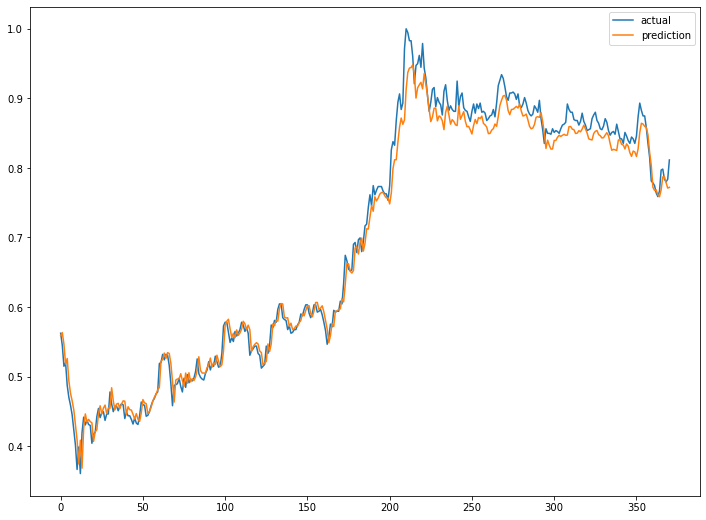

In [46]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[120:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [47]:
def RMSE(y_test, pred):
    return np.sqrt(mean_squared_error(y_test[120:], pred))

print('RMSE : ', RMSE(y_test, pred)) 

RMSE :  0.021272261771995996


In [48]:
r2_y_predict = r2_score(y_test[120:], pred)

print('R2 : ', r2_y_predict)

R2 :  0.9862510341034026


In [ ]:
val_lose 0.00013
RMSE : 0.01586393814653742
R2 : 0.9922155763036076

# 예측

In [123]:
data_y = np.array(data['y'])
data_y = data_y.reshape(-1,1)

In [124]:
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(data_y)

In [125]:
pred_data = windowed_dataset(scaled_y, WINDOW_SIZE, BATCH_SIZE, False)

In [137]:
pred_data

<PrefetchDataset shapes: ((None, None, 1, 1), (None, 1, 1)), types: (tf.float64, tf.float64)>

In [132]:
prediction = model.predict(pred_data)

In [144]:
prediction

array([[24790.197],
       [24144.01 ],
       [24479.06 ],
       ...,
       [74221.39 ],
       [73632.54 ],
       [73709.18 ]], dtype=float32)

In [134]:
prediction = scaler_y.inverse_transform(prediction)  # 0~1의 값으로 정규화된 값을 원래의 크기로 되돌린다.  
print("predicted 10 days later final price", prediction[-1])  # 예측한 값을 출력한다. 

predicted 10 days later final price [73709.18]


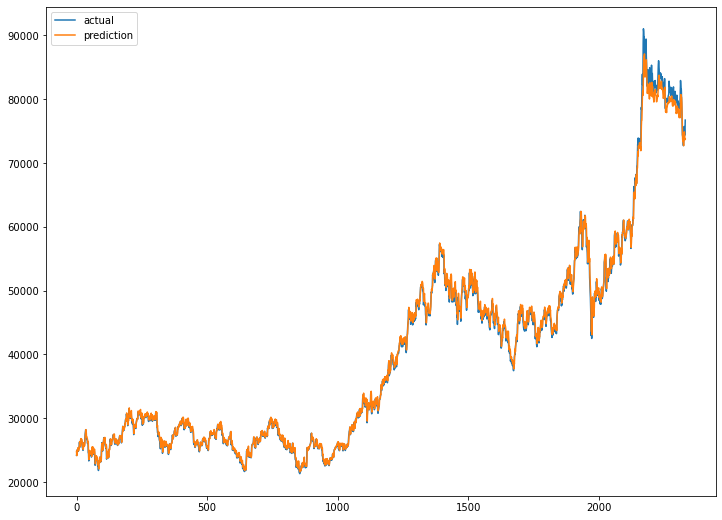

In [143]:
plt.figure(figsize=(12, 9))
plt.plot(data_y[120:], label='actual')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()

In [ ]:
save 기능